In [1]:
import csv
import os
import numpy as np
import pandas as pd
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

In [2]:
train_df = pd.read_csv('/hdd/datasets/sarcasm/train-balanced-sarcasm.csv')

In [3]:
train_df = train_df.drop(train_df.columns[[2,3,4,5,6,7,8,9]], axis=1)
print(train_df.head())

comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

   label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...
2      0  They were underdogs earlier today, but since G...
3      0  This meme isn't funny none of the "new york ni...
4      0                    I could use one of those tools.


In [ ]:
train_df['length'] = train_df['comment'].str.len()
train_df = train_df.dropna()

ax = train_df['length'].plot.hist()

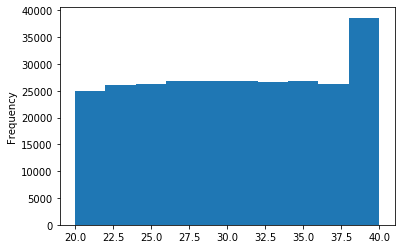

In [5]:
train_df = train_df[train_df['length'] <= 40]
train_df = train_df[train_df['length'] >= 20]
ax = train_df['length'].plot.hist()

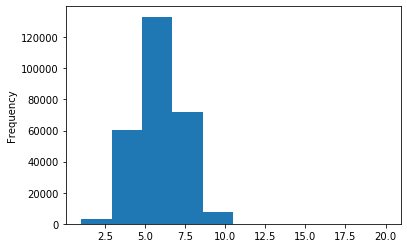

In [6]:
train_df['words'] = train_df['comment'].str.split().apply(len)
ax = train_df['words'].plot.hist()
train_df = train_df[train_df['words'] >= 4]
train_df = train_df[train_df['words'] <= 7]

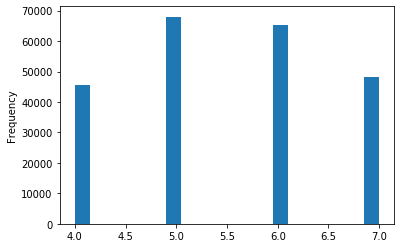

In [7]:
ax = train_df['words'].plot.hist(bins=20)

In [8]:
print(train_df.sort_index(by=['length'], ascending=False))
print(train_df['label'].value_counts())

        label                                   comment  length  words
121957      0  KENALKAN = pilihan kata yang lebih baik.    40.0      7
712719      1  Yeah but it's just because we're jealous    40.0      7
685393      1  The music definitely improved this video    40.0      6
909404      1  Are vaccinations also bad for your dogs?    40.0      7
485735      1  Stop being reasonable you stupid zionist    40.0      6
...       ...                                       ...     ...    ...
619907      1                      I miss CD Warehouse!    20.0      4
222064      0                      Too little too late.    20.0      4
619858      0                      What's on the stars?    20.0      4
619815      0                      20 cents a terabyte.    20.0      4
219503      0                      The state of denial?    20.0      4

[226826 rows x 4 columns]
1    116989
0    109837
Name: label, dtype: int64


/opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [9]:
comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

In [10]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(comments)

tokens = tokenizer.texts_to_sequences(comments)

print(comments[:2])
print(tokens[:2])

[['I', 'could', 'use', 'one', 'of', 'those', 'tools.'], ['Blade', 'Mastery+Masamune', 'or', 'GTFO!']]
[[5, 116, 142, 53, 11, 82], [61]]


In [11]:
MAX_SEQUENCE_LENGTH = 7
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = np.array(pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH))

Found 117913 unique tokens.


In [12]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
old_data = data[indices]
old_labels = train_df['label'].values[indices]
data = []
labels = []

for datum, label in zip(old_data, old_labels):
    if datum[3] != 0:
        data.append(datum)
        labels.append(label)
        
data = np.asarray(data)
labels = to_categorical(np.asarray(labels))
num_validation_samples = int(0.3 * data.shape[0])

In [13]:
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Number of entries in each category:')
print("Training:\n",y_train.sum(axis=0))
print("Validation:\n",y_val.sum(axis=0))

Number of entries in each category:
Training:
 [40165. 47616.]
Validation:
 [17221. 20399.]


In [14]:
EMBEDDING_DIM = 7
# GLOVE_DIR = "/hdd/datasets/sarcasm/"
# embeddings_index = {}
# f = open(os.path.join(GLOVE_DIR, 'glove.twitter.27B.25d.txt'))
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print("Found %s word vectors." % len(embeddings_index))

In [15]:
# embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

In [34]:
embedding_layer = Embedding(len(word_index) + 1,
                            3*EMBEDDING_DIM,
                            #weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

In [41]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 4, activation='relu')(embedded_sequences)
l_cov2= Conv1D(128, 4, activation='relu')(l_cov1)
l_flat = Flatten()(l_cov2)
drop = Dropout(0.5)(l_flat)
l_dense = Dense(256, activation='relu')(drop)
preds = Dense(2, activation='sigmoid')(l_dense)

In [42]:
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 7)]               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 7, 21)             2476194   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 4, 128)            10880     
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1, 128)            65664     
_________________________________________________________________
flatten_5 (Flatten)          (None, 128)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               3302

In [43]:
print("Training Progress:")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=32)

Training Progress:
Train on 87781 samples, validate on 37620 samples
Epoch 1/100
 7616/87781 [=>............................] - ETA: 14s - loss: 0.6113 - acc: 0.6526

KeyboardInterrupt: 